# Benchmark forecasting — validation + plots

Sections:
1. Setup & configuration  
2. Validation (temporal holdout + metrics + calibration)  
3. Plots (fit on full data + forecasts by category)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from forecasting import (
    load_dataset,
    prepare_dataset,
    ModelConfig,
    SamplingConfig,
    temporal_holdout,
    crps_score,
    point_error,
    fit,
    generate_forecast,
)

from plotting import (
    Theme,
    make_mpl_style,
    apply_style,
    plot_calibration_curve,
    plot_category_forecast,
)


## 1) Setup & configuration

In [2]:
# ---- Data ----
DATA_PATH = "benchmark_data_processed/all_normalized_updated_benchmarks.csv"

# ---- Model ----
CFG = ModelConfig(
    sigmoid="harvey",
    joint=True,
    top_n=3,
)

SAMP = SamplingConfig(
    draws=2000,
    tune=1000,
    target_accept=0.9,
    seed=42,
    progressbar=True,
)

# ---- Plot style ----
# A4 / slides: 1.0
# double-column: try 1.3–1.6
PLOT_SCALE = 1.0

apply_style(make_mpl_style(scale=PLOT_SCALE), reset=False)

THEME = Theme()  # override via: THEME = Theme().with_overrides(...)


## 2) Load & prepare data

In [3]:
raw = load_dataset(DATA_PATH)
data = prepare_dataset(raw, top_n=CFG.top_n)

data.head()


,model_version,score,release_date,organization,benchmark,stderr,source,lower_bound,category,days,days_mid
0,gpt2-xl,0.250,2019-11-05,OpenAI,ARC (AI2),NaN,EpochAI,0.25,Domain Specific Questions,0,939.0
1,GPT-Neo-2.7B,0.274,2021-03-21,NaN,ARC (AI2),NaN,EpochAI,0.25,Domain Specific Questions,502,939.0
2,gpt-j-6b,0.363,2021-08-05,"EleutherAI,LAION",ARC (AI2),NaN,EpochAI,0.25,Domain Specific Questions,639,939.0
3,GLaM (64B/64E) (Zero-shot),0.480,2021-12-13,NaN,ARC (AI2),NaN,EpochAI,0.25,Domain Specific Questions,769,939.0
4,GLaM (64B/64E) (One-shot),0.503,2021-12-13,NaN,ARC (AI2),NaN,EpochAI,0.25,Domain Specific Questions,769,939.0


## 3) Validation — temporal holdout

In [6]:
CUTOFF_DATE = pd.to_datetime("2025-01-01")

idata_val = temporal_holdout(
    raw,
    cutoff_date=CUTOFF_DATE,
    cfg=CFG,
    samp=SAMP,
    min_train_points=3,
)

print("CRPS:", crps_score(idata_val))
print("RMSE:", point_error(idata_val, metric="RMSE"))
print("MAE :", point_error(idata_val, metric="MAE"))


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 162 seconds.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

CRPS: 0.055659223566897176
RMSE: 0.10402384696563305
MAE : 0.07061504964535557


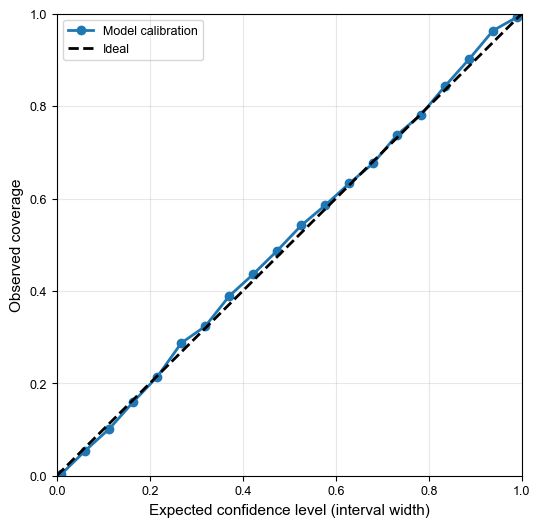

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_calibration_curve(idata_val, ax=ax, n_points=20)
plt.show()


## 4) Plots — fit on full data and forecast

In [8]:
idata, model = fit(data, CFG, SAMP)

END_DATE = pd.to_datetime("2030-03-01")
forecast_df = generate_forecast(
    idata,
    model,
    prepared_frontier=data,
    end_date=END_DATE,
    n_points=250,
    ci_level=0.8,
)

forecast_df.head()


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 133 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/antoinemaier/Documents/Semaphore/benchmark-forecasting/forecasting_clean.py:338: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _date_grid_for_benchmark(g, end_date=end_date, n_points=n_points))
Sampling: []


,release_date,days,benchmark,category,mu_mean,mu_lower,mu_upper
0,2019-11-05 00:00:00.000000000,0,ARC (AI2),Domain Specific Questions,0.293002,0.251397,0.343971
1,2019-11-20 03:16:37.590361445,15,ARC (AI2),Domain Specific Questions,0.294428,0.251595,0.346383
2,2019-12-05 06:33:15.180722891,30,ARC (AI2),Domain Specific Questions,0.295909,0.251830,0.348721
3,2019-12-20 09:49:52.771084337,45,ARC (AI2),Domain Specific Questions,0.297448,0.252096,0.351226
4,2020-01-04 13:06:30.361445783,60,ARC (AI2),Domain Specific Questions,0.299048,0.252399,0.353834


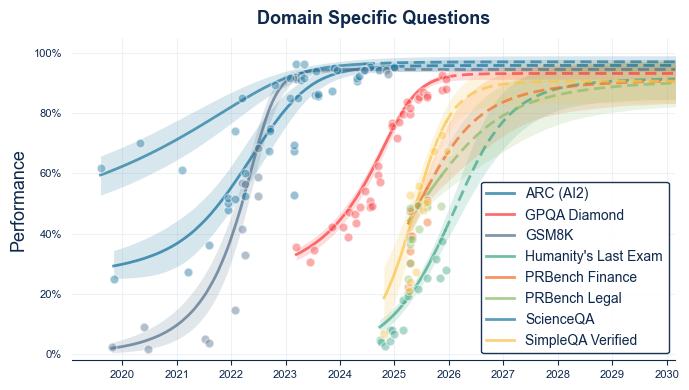

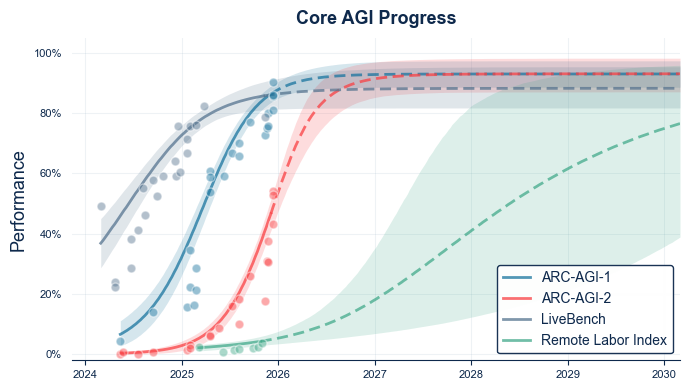

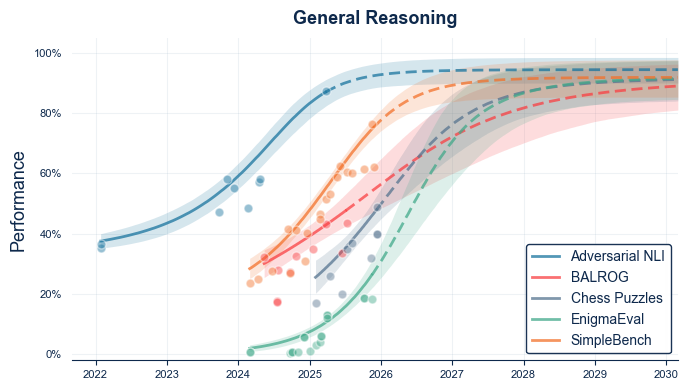

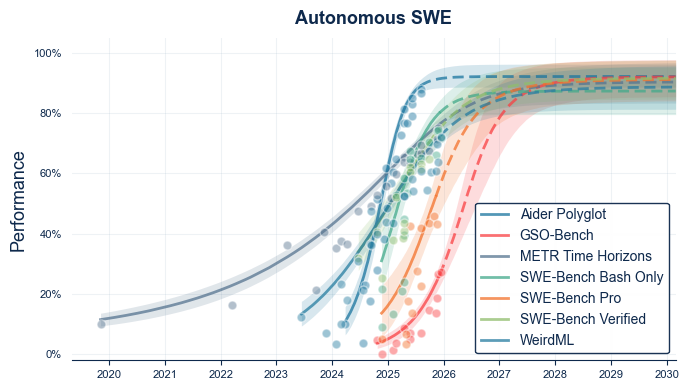

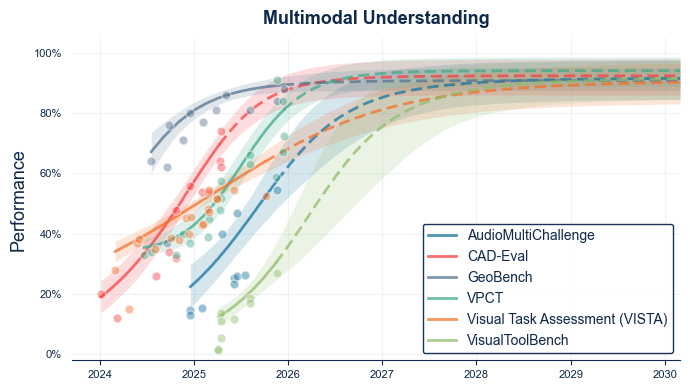

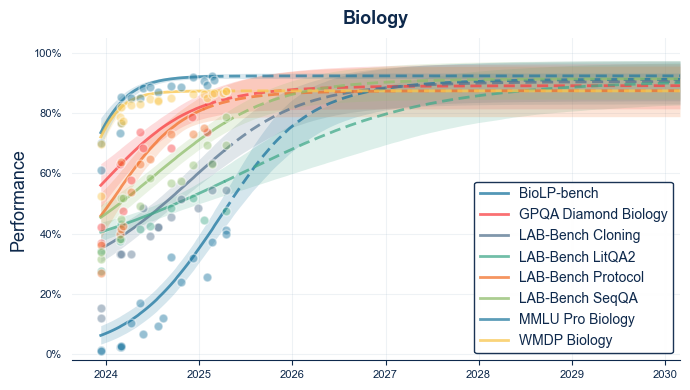

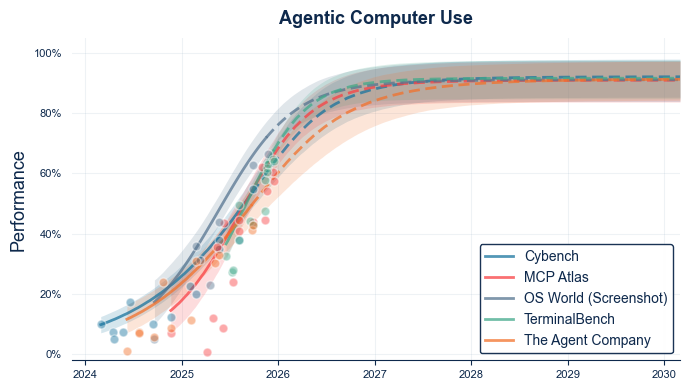

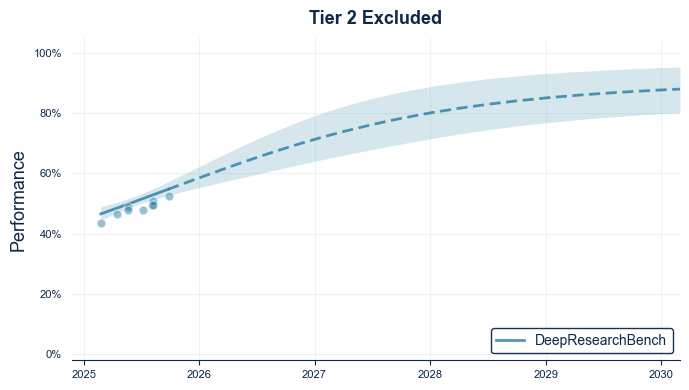

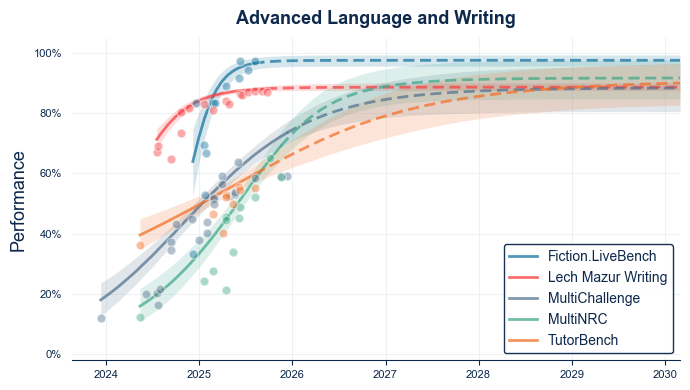

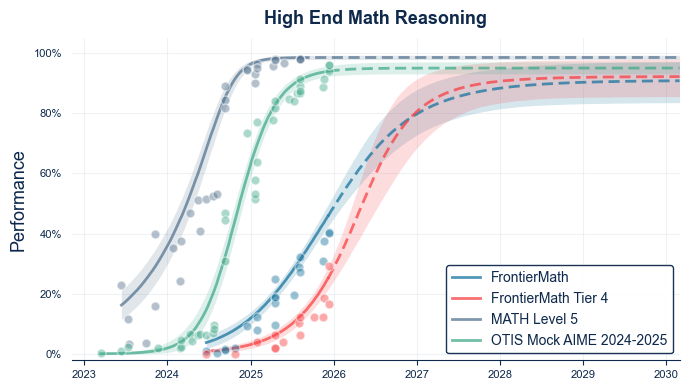

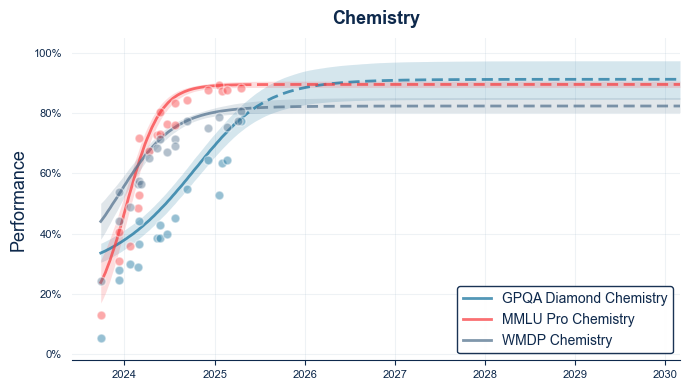

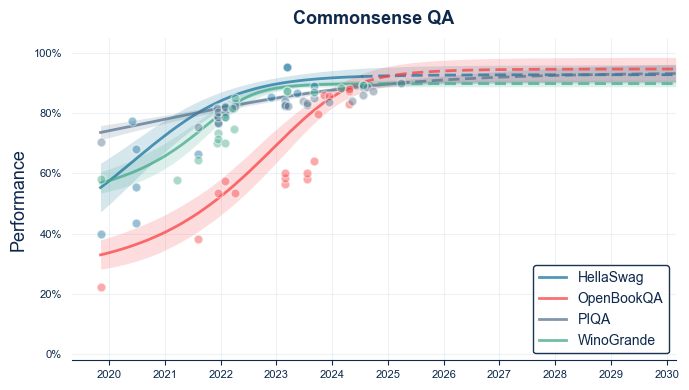

In [9]:
if "category" in data.columns:
    categories = list(data["category"].dropna().unique())
else:
    categories = ["all"]

for cat in categories:
    obs_cat = data if cat == "all" else data.loc[data["category"] == cat]
    pred_cat = forecast_df if cat == "all" else forecast_df.loc[forecast_df["category"] == cat]

    plot_category_forecast(
        observed=obs_cat,
        forecast=pred_cat,
        end_date=END_DATE,
        category_label=cat,
        theme=THEME,
        scale=PLOT_SCALE,
        figsize=(7, 4),
        ci_alpha=0.18,
        mean_alpha=0.75,
        scatter_alpha=0.45,
        dash_style=(0, (4, 2)),
    )
    plt.show()
